In [181]:
%pylab inline 
from glob import glob
import pandas as pd
from skimage import measure
from os.path import join, basename

Populating the interactive namespace from numpy and matplotlib


In [171]:
paths = glob('../../data/Lungs/*left.npy')
BORDER = .8
BORDER_VESSEL = 25
REAL_NODULE = True
NODULE_LABEL = 2
VESSEL_LABEL = 1


LOWER = 1000
UPPER = 2000

In [155]:
lung = load('../../data/Lungs/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179lungs_left.npy',)
diff = load('../../data/Lungs/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179diff_left.npy')

In [157]:
anotations.seriesuid

0       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
1       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
2       1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...
3       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
4       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
5       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
6       1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
7       1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...
8       1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...
9       1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...
10      1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985...
11      1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...
12      1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...
13      1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...
14      1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085...
15      1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...
16      1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065...
17      1.3.6.

In [147]:
def extract_patches(lung, diff, real_nodule=True):
    if real_nodule:
        candidate = diff == NODULE_LABEL
    else:
        candidate = diff == VESSEL_LABEL

    if not candidate.sum():
        return [], []

    patches = list()
    masks = list()

    labels, num = measure.label(candidate, background=0, return_num=True)
    for label in range(1, num + 1):
        coords = where(labels == label)
        min_max = list()
        deltas = list()

        for i, coord in enumerate(coords):
            min_max.append((coord.min(), coord.max()))
            deltas.append(int(BORDER * (min_max[-1][1] - min_max[-1][0])))
            deltas[-1] = (clip(min_max[-1][0] - deltas[-1], 0, lung.shape[i]),
                          clip(min_max[-1][1] + deltas[-1], 0, lung.shape[i]))

        patches.append(lung[deltas[0][0]:deltas[0][1], deltas[1][0]:deltas[1][1], deltas[2][0]:deltas[2][1]])
        masks.append(diff[deltas[0][0]:deltas[0][1], deltas[1][0]:deltas[1][1], deltas[2][0]:deltas[2][1]])

    return patches, masks

In [168]:
def extract_patches_vessels(lung, diff, amount=2):
    candidate = diff == VESSEL_LABEL
    if not candidate.sum():
        return [], []
    
    flag = 0
    start = 1
    
    labels, num = measure.label(candidate, background=0, return_num=True)
    
    marks = arange(start, num + 1)
    shuffle(marks)
    
    patches = list()
    masks = list()

        
    for i, label in enumerate(marks):
        if flag >= amount:
            return patches, masks
        
        overlaped = labels == label
        area = overlaped.sum()
        
        if area < LOWER or area > UPPER:
            continue
        print(area)
        coords = where(labels == label)
        
        medians = list()
        deltas = list()
        for j, coord in enumerate(coords):
            medians.append(median(coord))
            deltas.append((clip(int(medians[-1] - BORDER_VESSEL), 0, lung.shape[j]), 
                           clip(int(medians[-1] + BORDER_VESSEL), 0, lung.shape[j])))
        
        patches.append(lung[deltas[0][0]:deltas[0][1], deltas[1][0]:deltas[1][1], deltas[2][0]:deltas[2][1]])
        masks.append(diff[deltas[0][0]:deltas[0][1], deltas[1][0]:deltas[1][1], deltas[2][0]:deltas[2][1]])
        flag += 1
        
    return patches, masks

1675
1678
(50, 50, 50)


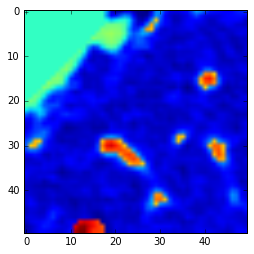

In [169]:
patches, masks = extract_patches_vessels(lung, diff)
print(patches[-1].shape)
imshow(patches[-1][25] + 1000 * masks[-1][25])

In [185]:
anotations = pd.read_csv('../../data/Lungs/annotations.csv')
preprocessed_files = asarray([basename(preprocessed_file).split('lungs.npy')[0]
                              for preprocessed_file in glob('../../data/Lungs/*lungs.npy')])

files_with_nodules = unique(anotations.seriesuid.values)
preprocessed_files_with_nodules = intersect1d(files_with_nodules, preprocessed_files)
preprocessed_files_pure = setdiff1d(preprocessed_files_with_nodules, preprocessed_files)

In [184]:
preprocessed_files_with_nodules

array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860',
       '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'], dtype=object)

In [186]:
preprocessed_files_pure

array([], dtype=object)

In [187]:
glob('../../data/Lungs/*lungs.npy')

['../../data/Lungs/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860lungs.npy',
 '../../data/Lungs/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059lungs.npy',
 '../../data/Lungs/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053lungs.npy']

In [188]:
setdiff1d([1,2,3], [2,3,4])

array([1])